LENDING - RF Version (c) Daniele Marazzina

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc, average_precision_score

In [8]:
df = pd.read_excel('lendingclub_fulldata.xlsx')
# 1 = good, 0 = default

# splitting in training and test...
train_predictors, rest_predictors, train_response, rest_response = train_test_split(
       df.drop('loan_status', axis=1), df['loan_status'], train_size=0.7, random_state=0)

# We set hyperparameters a priori --> no validation set required
test_predictors=rest_predictors
test_response=rest_response



In [9]:
  # model definition + training
n_estimators = 50
max_depth = 50
min_samples_split = 10
min_samples_leaf = 10
min_impurity_decrease = 0
parameters = {"n_estimators": n_estimators,
      "max_depth": max_depth,
      "min_samples_split": min_samples_split,
      "min_samples_leaf": min_samples_leaf,
     "min_impurity_decrease": min_impurity_decrease,
       }
classifier = RandomForestClassifier(**parameters)
classifier.fit(train_predictors, train_response)

RandomForestClassifier(max_depth=50, min_impurity_decrease=0,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=50)

In [10]:
y_test = test_response
y_pred = classifier.predict(test_predictors)

In [11]:
THRESHOLD = [.5, .75, .80, .85]
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "recall", "tnr", "fpr", "precision", "f1_score"]) # df to store results
results['THRESHOLD'] = THRESHOLD                                                                           # threshold column
n_test = len(y_test)
Q = classifier.predict_proba(test_predictors)[:,1]
j = 0                                                                                                      
for i in THRESHOLD:                                                                                        # iterate over each threshold        
                                                                         # fit data to model
    preds = np.where(Q>i, 1, 0)                                       # if prob > threshold, predict 1
    
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None)/n_test)*100 
    # confusion matrix (in percentage)
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]                                                                                          # True Positives
    FN = cm[0][1]                                                                                          # False Positives
    FP = cm[1][0]                                                                                          # True Negatives
    TN = cm[1][1]                                                                                          # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)                                                                         # True negative rate
    results.iloc[j,4] = FP/(FP+TN)                                                                         # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
    j += 1

print('ALL METRICS')
print(results.T.to_string(header=False))

Confusion matrix for threshold = 0.5
[[8.25045620e+01 6.84306569e-02]
 [1.74041971e+01 2.28102190e-02]]
 
Confusion matrix for threshold = 0.75
[[66.9479927 15.625    ]
 [12.5        4.9270073]]
 
Confusion matrix for threshold = 0.8
[[54.12864964 28.44434307]
 [ 9.44343066  7.98357664]]
 
Confusion matrix for threshold = 0.85
[[37.47718978 45.09580292]
 [ 5.8850365  11.5419708 ]]
 
ALL METRICS
THRESHOLD        0.5      0.75       0.8      0.85
accuracy    0.825274   0.71875  0.621122  0.490192
recall      0.999171  0.810773  0.655525  0.453867
tnr        0.0013089  0.282723  0.458115  0.662304
fpr         0.998691  0.717277  0.541885  0.337696
precision   0.825799  0.842664  0.851453  0.864282
f1_score     0.90425  0.826411  0.740752  0.595182


In [12]:
# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, Q)
roc_auc = auc(fpr,tpr)

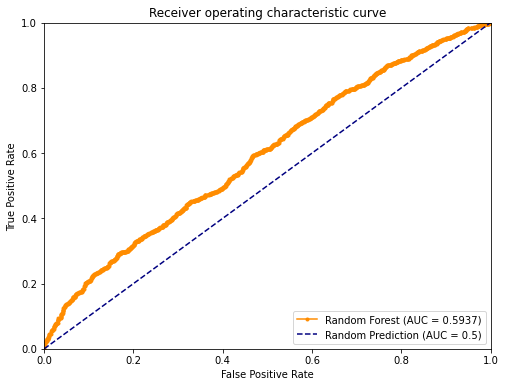

In [13]:
plt.figure(figsize=(8,6))      # format the plot size
lw = 1.5
plt.plot(fpr, tpr, color='darkorange', marker='.',
         lw=lw, label='Random Forest (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label='Random Prediction (AUC = 0.5)' )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()